# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import PercentFormatter

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [359]:
from mlxtend.plotting import plot_decision_regions
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingRegressor, RandomForestRegressor,
                              VotingClassifier)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler,
                                   Normalizer, StandardScaler, normalize,
                                   scale)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Functions

In [42]:
def plot_labeled_decision_regions(X, y, models):
    """
    Function producing a scatter plot of the instances contained
    in the 2D dataset (X,y) along with the decision
    regions of two trained classification models contained in the
    list 'models'.

    Parameters
    ----------
    X: pandas DataFrame corresponding to two numerical features
    y: pandas Series corresponding the class labels
    models: list containing two trained classifiers

    """
    if len(models) != 2:
        raise Exception(
            """
        Models should be a list containing only two trained classifiers.
        """
        )
    if not isinstance(X, pd.DataFrame):
        raise Exception(
            """
        X has to be a pandas DataFrame with two numerical features.
        """
        )
    if not isinstance(y, pd.Series):
        raise Exception(
            """
        y has to be a pandas Series corresponding to the labels.
        """
        )
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    for i, model in enumerate(models):
        plot_decision_regions(X.values, y.values, model, legend=2, ax=ax[i])
        ax[i].set_title(model.__class__.__name__)
        ax[i].set_xlabel(X.columns[0])
        if i == 0:
            ax[i].set_ylabel(X.columns[1])
        ax[i].set_ylim(X.values[:, 1].min(), X.values[:, 1].max())
        ax[i].set_xlim(X.values[:, 0].min(), X.values[:, 0].max())
    plt.tight_layout()
    plt.show()

In [328]:
def plot_feature_importances(X, model):
    rf_std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    rf_importances = pd.DataFrame(
        dict(feature=X.columns, importance=rf.feature_importances_, errs=rf_std)
    )
    rf_importances.sort_values(by=["importance"], ascending=False, inplace=True)
    sns.barplot(x="importance", y="feature", data=rf_importances)
    plt.errorbar(
        y=range(len(rf_importances.feature)),
        x=rf_importances.importance,
        xerr=rf_importances.errs,
        fmt="none",
        c="black",
    )

# Classification and Regression Trees (CARTs)

## Cancer (Classification)

### Data

In [60]:
df = pd.read_csv("datasets/wbc.csv")
df.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
294,891716,B,12.72,13.78,81.78,492.1,0.09667,0.08393,0.01288,0.01924,...,17.48,88.54,553.7,0.1298,0.14720,0.05233,0.06343,0.2369,0.06922,NaN
209,8810436,B,15.27,12.91,98.17,725.5,0.08182,0.06230,0.05892,0.03157,...,15.92,113.70,932.7,0.1222,0.21860,0.29620,0.10350,0.2320,0.07474,NaN
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.66560,0.71190,0.26540,0.4601,0.11890,NaN
229,881861,M,12.83,22.33,85.26,503.2,0.10880,0.17990,0.16950,0.06861,...,30.15,105.30,706.0,0.1777,0.53430,0.62820,0.19770,0.3407,0.12430,NaN
351,899667,M,15.75,19.22,107.10,758.6,0.12430,0.23640,0.29140,0.12420,...,24.17,119.40,915.3,0.1550,0.50460,0.68720,0.21350,0.4245,0.10500,NaN
518,917062,B,12.88,18.22,84.45,493.1,0.12180,0.16610,0.04825,0.05303,...,24.37,99.31,674.7,0.1456,0.29610,0.12460,0.10960,0.2582,0.08893,NaN
92,861853,B,13.27,14.76,84.74,551.7,0.07355,0.05055,0.03261,0.02648,...,22.35,104.50,830.6,0.1006,0.12380,0.13500,0.10010,0.2027,0.06206,NaN
23,851509,M,21.16,23.04,137.20,1404.0,0.09428,0.10220,0.10970,0.08632,...,35.59,188.00,2615.0,0.1401,0.26000,0.31550,0.20090,0.2822,0.07526,NaN
69,859487,B,12.78,16.49,81.37,502.5,0.09831,0.05234,0.03653,0.02864,...,19.76,85.67,554.9,0.1296,0.07061,0.10390,0.05882,0.2383,0.06410,NaN
396,90401601,B,13.51,18.89,88.10,558.1,0.10590,0.11470,0.08580,0.05381,...,27.20,97.33,675.2,0.1428,0.25700,0.34380,0.14530,0.2666,0.07686,NaN


In [63]:
target = "diagnosis"
df[target] = df[target].astype("category").cat.codes
y = df[target]
X = df.drop(target, axis=1)[["radius_mean", "concave points_mean"]]  # .to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

### Decision Tree

In [64]:
# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion="gini", random_state=1)
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion="entropy", random_state=1)

# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred = dt_gini.predict(X_test)
accuracy_gini = accuracy_score(y_test, y_pred)
y_pred = dt_entropy.predict(X_test)
accuracy_entropy = accuracy_score(y_test, y_pred)

# Print accuracy
print("Accuracy achieved by using entropy: ", accuracy_entropy)
print("Accuracy achieved by using the gini index: ", accuracy_gini)

Accuracy achieved by using entropy:  0.8859649122807017
Accuracy achieved by using the gini index:  0.9210526315789473


In [65]:
# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=6, random_state=1)

# Setup the hyperparameter grid
param_grid = {"criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object: logreg_cv
dt_cv = GridSearchCV(dt, param_grid, n_jobs=-1)

# Fit it to the data
dt_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print(f"CV tuned params: {dt_cv.best_params_}")
print(f"CV best accuracy: {dt_cv.best_score_}")

# Predict test set labels
y_pred = dt_cv.predict(X_test)
print(f"Sample predictions: {y_pred[0:5]}")

# Compute test set accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {acc}")

CV tuned params: {'criterion': 'entropy'}
CV best accuracy: 0.8967032967032967
Sample predictions: [1 0 0 1 0]
Test set accuracy: 0.8947368421052632


### Logistic Regression

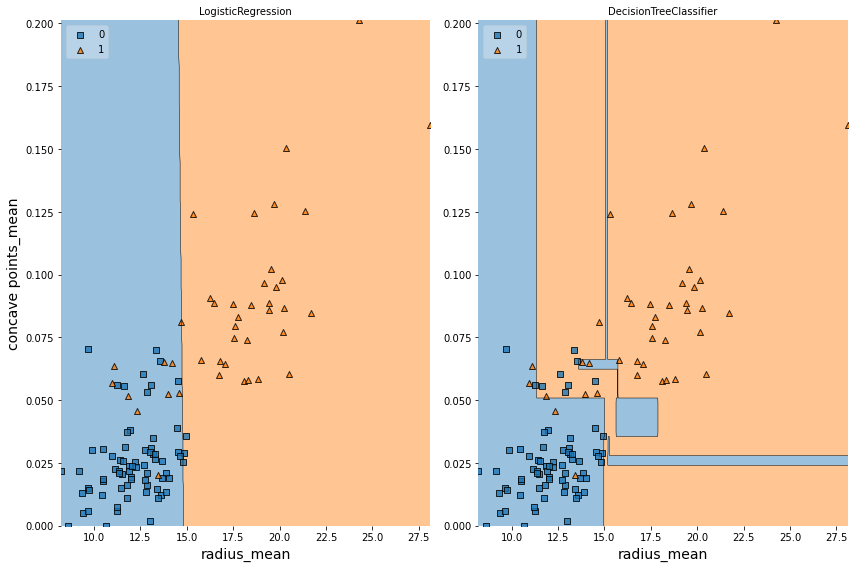

In [43]:
# Instatiate logreg
logreg = LogisticRegression(random_state=1)

# Fit logreg to the training set
logreg.fit(X_train, y_train)

# Define a list called clfs containing the two classifiers logreg and dt
clfs = [logreg, dt]

# Review the decision regions of the two classifiers
plot_labeled_decision_regions(X_test, y_test, clfs)

## Auto MPG (Regression)

### Data

In [224]:
df = pd.read_csv("datasets/auto.csv")
df.sample(10)

,mpg,displ,hp,weight,accel,origin,size
224,34.5,105.0,70,2150,14.9,US,10.0
90,24.5,98.0,60,2164,22.1,US,10.0
209,19.4,232.0,90,3210,17.2,US,15.0
385,20.0,156.0,122,2807,13.5,Asia,15.0
113,13.0,400.0,170,4746,12.0,US,20.0
372,10.0,307.0,200,4376,15.0,US,20.0
53,28.4,151.0,90,2670,16.0,US,10.0
122,15.0,318.0,150,3777,12.5,US,20.0
261,12.0,350.0,160,4456,13.5,US,20.0
20,19.0,225.0,95,3264,16.0,US,15.0


In [225]:
df = pd.get_dummies(df)
df.sample(10)

,mpg,displ,hp,weight,accel,size,origin_Asia,origin_Europe,origin_US
161,28.0,151.0,90,2678,16.5,10.0,0,0,1
113,13.0,400.0,170,4746,12.0,20.0,0,0,1
297,16.2,163.0,133,3410,15.8,15.0,0,1,0
274,21.0,200.0,85,2587,16.0,15.0,0,0,1
318,29.0,97.0,78,1940,14.5,10.0,0,1,0
4,34.3,97.0,78,2188,15.8,10.0,0,1,0
243,29.8,134.0,90,2711,15.5,10.0,1,0,0
183,25.0,121.0,115,2671,13.5,10.0,0,1,0
220,13.0,318.0,150,3940,13.2,20.0,0,0,1
39,29.0,85.0,52,2035,22.2,10.0,0,0,1


In [226]:
target = "mpg"
y = df[target]
X = df.drop(target, axis=1)

### Baseline Model

The baseline RMSE above which a model is considered to be underfitting and below which the model is considered good enough.

In [227]:
# keep a single feature
X_naive = X["displ"].to_numpy().reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X_naive, y, test_size=0.2, random_state=3
)
dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred)
rmse_baseline = np.sqrt(mse_baseline)

### Decision Tree

In [228]:
# Set SEED for reproducibility
SEED = 1

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

# Instantiate a DecisionTreeRegressor dt
dt_cv = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.26, random_state=SEED)

# Compute the array containing the 10-folds CV MSEs
mse_cv_scores = -cross_val_score(
    dt_cv, X_train, y_train, cv=10, scoring="neg_mean_squared_error", n_jobs=-1
)

# Compute the 10-folds CV RMSE
rmse_dt_cv = (mse_cv_scores.mean()) ** (1.0 / 2.0)

In [229]:
# Fit dt to the training set
dt_cv.fit(X_train, y_train)

# Predict the labels of the training set
y_pred = dt_cv.predict(X_train)

# Evaluate the training set RMSE of dt
rmse_dt_train = (mean_squared_error(y_train, y_pred)) ** (1.0 / 2.0)

In [230]:
# run on test set
y_pred = dt_cv.predict(X_test)
rmse_dt_test = np.sqrt(mean_squared_error(y_test, y_pred))

### Random Forest

In [302]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred))

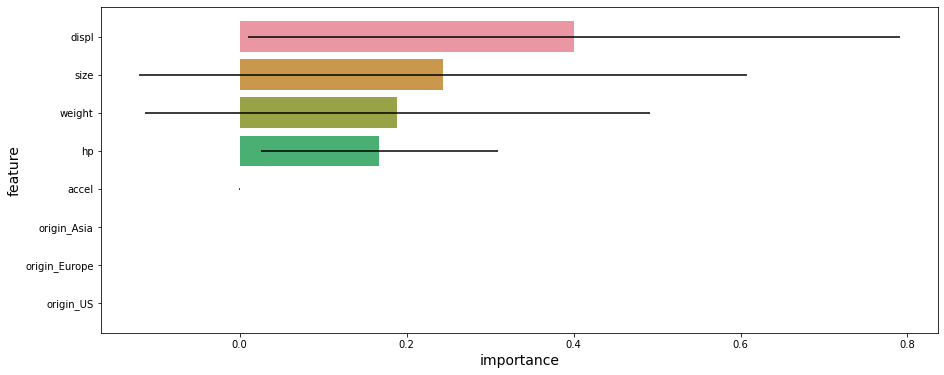

In [306]:
plot_feature_importances(X, rf)

### Linear Regression

In [236]:
# linear regression for comparison
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))

### Bias Variance Evaluation

In [237]:
print(f"Baseline: {rmse_baseline}")
print()
print(f"DT CV: {rmse_dt_cv}")
print(f"DT Train: {rmse_dt_train}")
print()
print(f"LR: {rmse_lr}")
print(f"DT Test: {rmse_dt_test}")
print()
print(f"RF Test: {rmse_rf_test}")

Baseline: 5.040821910883998

DT CV: 5.143255076652255
DT Train: 5.151299302408305

LR: 3.820965511082005
DT Test: 4.859775831709125

RF Test: 3.9783131439894097


It appears the `dt_cv` model suffers from high bias because `rmse_dt_cv` $\approx$ `rmse_dt_train` and both scores are greater than `rmse_baseline`. Thus, the `dt_cv` model appears to be underfitting the training set since the model is too constrained to capture the nonlinear dependencies between features and labels.

# Ensembles

## Cancer

### Data

In [332]:
df = pd.read_csv("datasets/wbc.csv")
df.sample(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
54,857438,M,15.10,22.02,97.26,712.8,0.09056,0.07081,0.05253,0.03334,...,31.69,117.70,1030.0,0.1389,0.2057,0.27120,0.15300,0.2675,0.07873,NaN
323,895100,M,20.34,21.51,135.90,1264.0,0.11700,0.18750,0.25650,0.15040,...,31.86,171.10,1938.0,0.1592,0.4492,0.53440,0.26850,0.5558,0.10240,NaN
418,906024,B,12.70,12.17,80.88,495.0,0.08785,0.05794,0.02360,0.02402,...,16.92,88.12,566.9,0.1314,0.1607,0.09385,0.08224,0.2775,0.09464,NaN
474,911391,B,10.88,15.62,70.41,358.9,0.10070,0.10690,0.05115,0.01571,...,19.35,80.78,433.1,0.1332,0.3898,0.33650,0.07966,0.2581,0.10800,NaN
134,867739,M,18.45,21.91,120.20,1075.0,0.09430,0.09709,0.11530,0.06847,...,31.39,145.60,1590.0,0.1465,0.2275,0.39650,0.13790,0.3109,0.07610,NaN
239,88330202,M,17.46,39.28,113.40,920.6,0.09812,0.12980,0.14170,0.08811,...,44.87,141.20,1408.0,0.1365,0.3735,0.32410,0.20660,0.2853,0.08496,NaN
36,854268,M,14.25,21.72,93.63,633.0,0.09823,0.10980,0.13190,0.05598,...,30.36,116.20,799.6,0.1446,0.4238,0.51860,0.14470,0.3591,0.10140,NaN
317,894326,M,18.22,18.87,118.70,1027.0,0.09746,0.11170,0.11300,0.07950,...,25.00,140.90,1485.0,0.1434,0.2763,0.38530,0.17760,0.2812,0.08198,NaN
214,8810955,M,14.19,23.81,92.87,610.7,0.09463,0.13060,0.11150,0.06462,...,34.85,115.00,811.3,0.1559,0.4059,0.37440,0.17720,0.4724,0.10260,NaN
495,914333,B,14.87,20.21,96.12,680.9,0.09587,0.08345,0.06824,0.04951,...,28.48,103.90,783.6,0.1216,0.1388,0.17000,0.10170,0.2369,0.06599,NaN


In [333]:
target = "diagnosis"
df[target] = df[target].astype("category").cat.codes
y = df[target]
X = df.drop(target, axis=1)[["radius_mean", "concave points_mean"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)

### Voting

In [334]:
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
classifiers = [("LogisticRegression", lr), ("KNN", knn), ("DecisionTree", dt)]

for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf_name:20s} :: {accuracy:0.3f}")

vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting :: {accuracy:0.3f}")

LogisticRegression   :: 0.877
KNN                  :: 0.865
DecisionTree         :: 0.912
Voting :: 0.877


### Bagging w/ OOB

In [335]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=1)
bc = BaggingClassifier(base_estimator=dt, oob_score=True, n_estimators=300, n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_oob = bc.oob_score_
print(f"Bagging Classifier Test :: {accuracy:0.3f}")
print(f"Bagging Classifier OOB :: {accuracy_oob:0.3f}")

Bagging Classifier Test :: 0.877
Bagging Classifier OOB :: 0.917


### Boosting

In [349]:
# decision stump
dt = DecisionTreeClassifier(max_depth=1, random_state=1)

# adaboost the stumps
adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=100)

# fit
adb_clf.fit(X_train, y_train)
y_pred_proba = adb_clf.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC score: {score}")

ROC score: 0.9575788551401869


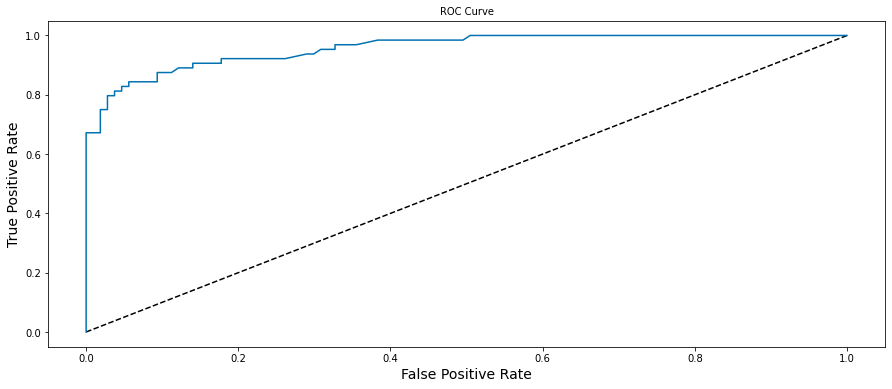

In [346]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

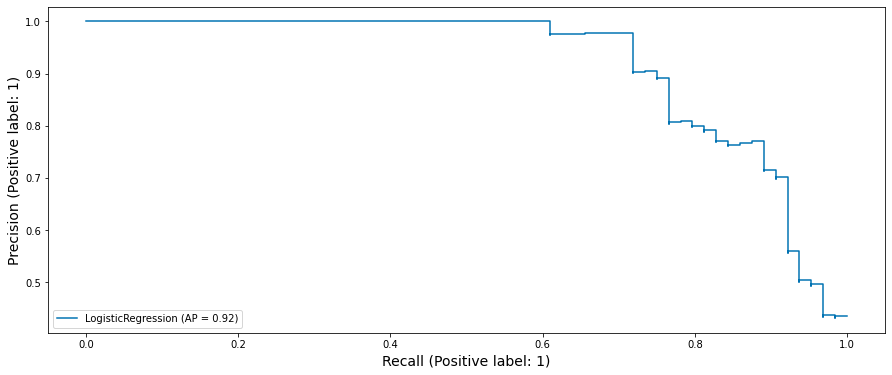

In [348]:
disp = plot_precision_recall_curve(logreg, X_test, y_test)

## Liver Disease

### Data

In [350]:
df = pd.read_csv("datasets/indian_liver_patient_preprocessed.csv")
df.sample(10)

,Unnamed: 0,Age_std,Total_Bilirubin_std,Direct_Bilirubin_std,Alkaline_Phosphotase_std,Alamine_Aminotransferase_std,Aspartate_Aminotransferase_std,Total_Protiens_std,Albumin_std,Albumin_and_Globulin_Ratio_std,Is_male_std,Liver_disease
133,133,0.507017,-0.388178,-0.388807,-0.219297,-0.350369,-0.332923,0.109170,-0.300492,-0.460559,1,1
523,527,-0.295067,0.029672,0.037623,0.027260,-0.071718,0.309343,0.570550,0.329431,-0.147390,1,1
187,187,0.938909,-0.195324,-0.175592,-0.412433,0.179615,0.471636,-2.290010,-1.938290,-1.086898,1,1
271,274,-0.726959,-0.243537,-0.246664,-0.391887,-0.306659,-0.305299,1.401035,1.085338,0.165780,1,1
459,463,-1.220549,-0.404249,-0.495414,-0.663099,-0.317586,-0.236238,1.401035,1.085338,0.165780,1,1
448,452,0.815511,-0.388178,-0.459878,3.322906,-0.306659,-0.256957,0.570550,0.455416,-0.147390,1,1
347,351,-0.480164,-0.323893,-0.388807,-0.395996,-0.219239,-0.250050,-1.090420,-1.308368,-1.086898,1,1
289,292,0.013427,-0.436391,-0.459878,-0.190532,-0.323050,-0.298393,0.570550,0.329431,-0.147390,1,1
524,528,0.013427,-0.259608,-0.246664,0.097118,-0.377687,-0.250050,-0.167659,-1.308368,-1.400067,1,1
109,109,-0.541862,-0.388178,-0.495414,0.799806,-0.306659,-0.263863,-0.536763,-0.426476,-0.147390,1,0


In [351]:
target = "Liver_disease"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Voting

In [352]:
# Instantiate lr
lr = LogisticRegression(random_state=1)

# Instantiate knn
knn = KNeighborsClassifier(n_neighbors=27)

# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=1)

# Define the list classifiers
classifiers = [
    ("Logistic Regression", lr),
    ("K Nearest Neighbours", knn),
    ("Classification Tree", dt),
]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:

    # Fit clf to the training set
    clf.fit(X_train, y_train)

    # Predict y_pred
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluate clf's accuracy on the test set
    print(f"{clf_name:s} : {accuracy:.3f}")

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)

# Fit vc to the training set
vc.fit(X_train, y_train)

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_pred, y_test)
print(f"Voting Classifier: {accuracy:.3f}")

Logistic Regression : 0.764
K Nearest Neighbours : 0.724
Classification Tree : 0.730
Voting Classifier: 0.764


/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

### Bagging w/ OOB

In [353]:
# Instantiate dt
dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=1)

# Instantiate bc
bc = BaggingClassifier(
    base_estimator=dt, oob_score=True, n_estimators=50, random_state=1
)

In [354]:
# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate acc_test
accuracy = accuracy_score(y_test, y_pred)
accuracy_oob = bc.oob_score_
print(f"Bagging Classifier Test :: {accuracy:0.3f}")
print(f"Bagging Classifier OOB :: {accuracy_oob:0.3f}")

Bagging Classifier Test :: 0.695
Bagging Classifier OOB :: 0.677


### Adaboost w/ DT

In [356]:
# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)

# Instantiate ada
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:, 1]

In [358]:
# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print(f"ROC AUC score: {ada_roc_auc:.2f}")

ROC AUC score: 0.72


## Bike Sharing

### Data

In [313]:
df = pd.read_csv("datasets/bikes.csv")
df.columns = [c.lower().replace(" ", "_") for c in df.columns]
df.sample(10)

,hr,holiday,workingday,temp,hum,windspeed,cnt,instant,mnth,yr,clear_to_partly_cloudy,light_precipitation,misty
880,16,0,1,0.84,0.41,0.1045,451,13884,8,1,1,0,0
1281,9,0,1,0.70,0.70,0.0000,412,14285,8,1,0,0,1
44,20,0,1,0.78,0.43,0.1343,395,13048,7,1,1,0,0
495,15,0,0,0.60,0.88,0.2537,380,13499,7,1,0,1,0
688,16,0,0,0.80,0.43,0.1343,521,13692,7,1,1,0,0
1015,7,0,0,0.64,0.65,0.1343,39,14019,8,1,1,0,0
232,16,0,1,0.80,0.43,0.2239,435,13236,7,1,1,0,0
8,8,0,0,0.78,0.62,0.1045,142,13012,7,1,1,0,0
135,15,0,1,0.92,0.29,0.1940,285,13139,7,1,1,0,0
1162,10,0,0,0.70,0.54,0.1642,480,14166,8,1,1,0,0


In [322]:
target = "cnt"
y = df[target]
X = df.drop(target, axis=1)

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [324]:
# Instantiate rf
rf = RandomForestRegressor(n_estimators=25, random_state=2)

# Fit rf to the training set
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25, random_state=2)

In [325]:
# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Print rmse_test
print(f"Test set RMSE of rf: {rmse_test:.2f}")

Test set RMSE of rf: 51.84


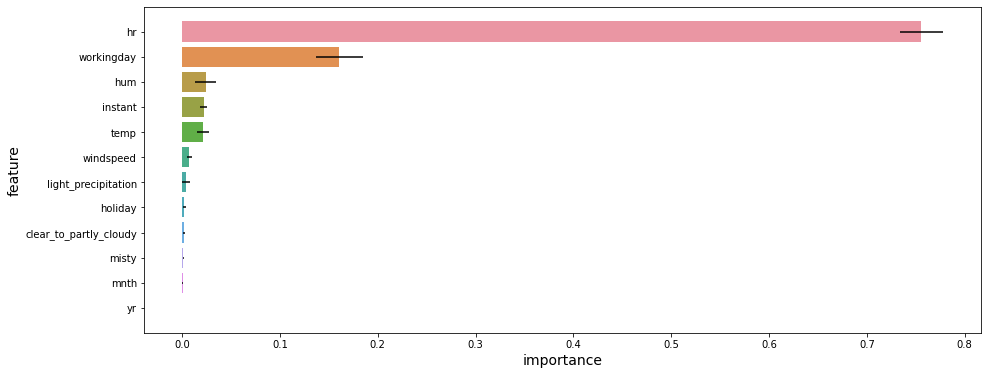

In [329]:
plot_feature_importances(X, rf)